# Brick element Response

Supported Brick elements include most brick elements in OpenSees, including:

- ✅ stdBrick
- ✅ bbarBrick
- ✅ Brick20N
- ✅ SSPbrick
- ✅ FourNodeTetrahedron
- ✅ brickUP
- ✅ bbarBrickUP
- ✅ 20_8_BrickUP
- ✅ SSPbrickUP
- ✅ ......

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops

import opstool as opst

In [2]:
opst.load_ops_examples("Pier-Brick")
# or your model code here

In [3]:
# add gravity loads
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
_ = opst.pre.gen_grav_load(direction="z", factor=-9.81)

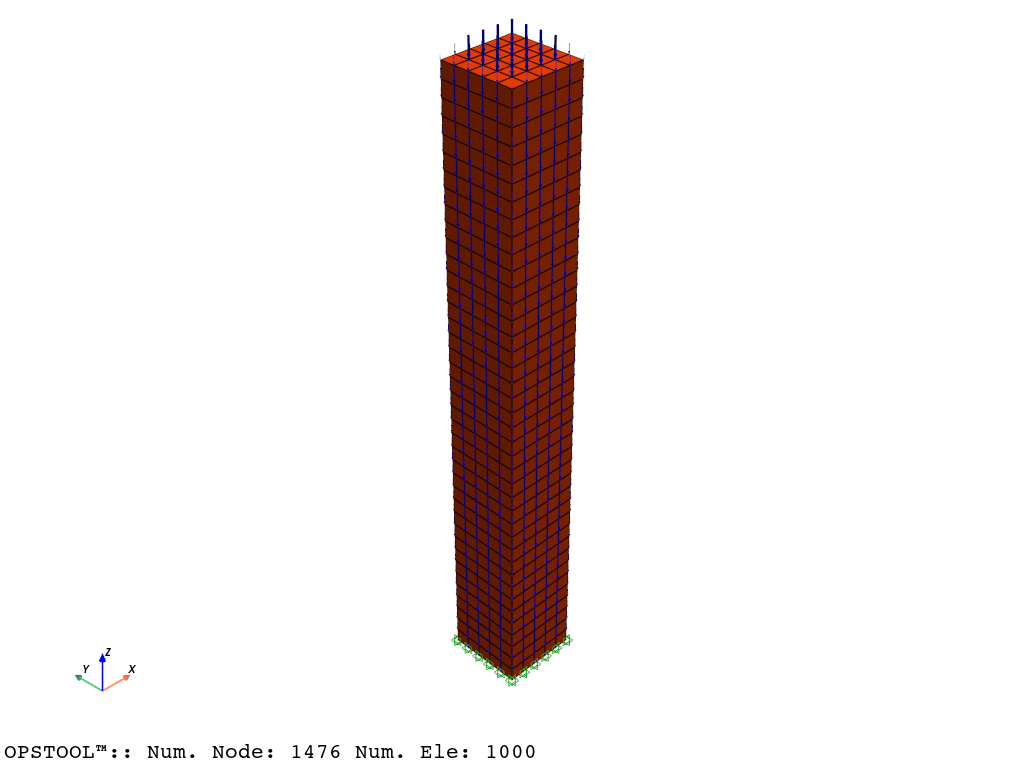

In [4]:
# plot
opst.vis.pyvista.set_plot_props(notebook=True)
fig = opst.vis.pyvista.plot_model(show_nodal_loads=True)
fig.show(jupyter_backend="static")

## Result Saving

In [5]:
Nsteps = 100

ops.system("BandGeneral")
# Create the constraint handler, the transformation method
ops.constraints("Transformation")
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer("RCM")
# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test("NormDispIncr", 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm("Newton")
# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator("LoadControl", 1 / Nsteps)
# Create the analysis object
ops.analysis("Static")

``compute_mechanical_measures`` is used to compute the mechanical measures, including various stress and strain measures.

``project_gauss_to_nodes`` is used to project the Gauss point results to the nodes.

* "copy": The response of each node is copied from the Gaussian point closest to it.
* "average": The response of each node is equal to the weighted average of the responses of all Gaussian points of the element, with the weight being the integration point weight.
* "extrapolate": The nodal responses are obtained by extrapolating the element shape functions.

In [6]:
ODB = opst.post.CreateODB(
    odb_tag=1,
    compute_mechanical_measures=True,
    project_gauss_to_nodes="copy",  # "extrapolate", "copy", "average"
)
for i in range(Nsteps):
    # Perform the analysis step
    ops.analyze(1)
    # fetch the response step, every 10 steps for reducing the size of the ODB file
    if (i + 1) % 10 == 0:
        ODB.fetch_response_step()
    # ODB.fetch_response_step()   # or every step
ODB.save_response()  # save the response to a file

OPSTOOL™ ::  All responses data with _odb_tag = 1 saved in 
g:\opstool\docs\src\post\.opstool.output\RespStepData-1.odb!

## Result Reading

In [7]:
info = opst.post.get_element_responses_info(ele_type="Solid")

ele_type: Solid
Available Response Types (resp_type):
  - Stresses
    resp_dim: ['time', 'eleTags', 'GaussPoints', 'stressDOFs']
    resp_dof: ['sigma11', 'sigma22', 'sigma33', 'sigma12', 'sigma23']
  - Strains
    resp_dim: ['time', 'eleTags', 'GaussPoints', 'strainDOFs']
    resp_dof: ['eps11', 'eps22', 'eps33', 'eps12', 'eps23', 'eps13']
  - StressesAtNodes
    resp_dim: ['time', 'nodeTags', 'stressDOFs']
    resp_dof: ['sigma11', 'sigma22', 'sigma33', 'sigma12', 'sigma23']
  - StressAtNodesErr
    resp_dim: ['time', 'nodeTags', 'stressDOFs']
    resp_dof: ['sigma11', 'sigma22', 'sigma33', 'sigma12', 'sigma23']
  - StrainsAtNodes
    resp_dim: ['time', 'nodeTags', 'strainDOFs']
    resp_dof: ['eps11', 'eps22', 'eps33', 'eps12', 'eps23', 'eps13']
  - StrainsAtNodesErr
    resp_dim: ['time', 'nodeTags', 'strainDOFs']
    resp_dof: ['eps11', 'eps22', 'eps33', 'eps12', 'eps23', 'eps13']
  - PorePressureAtNodes
    resp_dim: ['time', 'nodeTags']
    resp_dof: None



In [8]:
all_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Solid")

OPSTOOL™ ::  Loading Solid response data from g:\opstool\docs\src\post\.opstool.output\RespStepData-1.odb ...

The result is an ``xarray DataSet`` object, and we can access the associated DataArray objects through ``.data_vars``.

In [9]:
all_resp.data_vars

Data variables:
    PorePressureAtNodes    (time, nodeTags) float64 130kB 0.0 0.0 ... 0.0 0.0
    Strains                (time, eleTags, GaussPoints, strainDOFs) float32 2MB ...
    StrainsAtNodes         (time, nodeTags, strainDOFs) float32 390kB 0.0 ......
    StrainsAtNodesErr      (time, nodeTags, strainDOFs) float32 390kB 0.0 ......
    StressAtNodesErr       (time, nodeTags, stressDOFs) float32 390kB 0.0 ......
    Stresses               (time, eleTags, GaussPoints, stressDOFs) float32 2MB ...
    StressesAtNodes        (time, nodeTags, stressDOFs) float32 390kB 0.0 ......
    StressMeasures         (time, eleTags, GaussPoints, measures) float32 2MB ...
    StressMeasuresAtNodes  (time, nodeTags, measures) float32 455kB 0.0 ... 1...

``Stresses`` and ``Strains`` refer to the stress and strain at the Gauss points. 
Stress and strain consist of six components aligned with the global coordinate system, as well as additional stress measures:

In [10]:
print(all_resp.stressDOFs.data)
print(all_resp.strainDOFs.data)
print(all_resp.measures.data)

['sigma11' 'sigma22' 'sigma33' 'sigma12' 'sigma23' 'sigma13']
['eps11' 'eps22' 'eps33' 'eps12' 'eps23' 'eps13']
['p1' 'p2' 'p3' 'sigma_vm' 'sigma_oct' 'tau_oct' 'tau_max']


Although we analyzed 100 steps, we saved the data every 10 steps, so we only have data for 10 steps, and the time corresponds accordingly.

In [11]:
print(all_resp.time.data)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [12]:
all_resp.attrs  # attributes

{'sigma11, sigma22, sigma33': 'Normal stress (strain) along x, y, z.',
 'sigma12, sigma23, sigma13': 'Shear stress (strain).',
 'para#i': 'The additional output of stress, which is useful for some elements, such as * eta_r * for some u-p elements. eta_r--Ratio between the shear (deviatoric) stress and peak shear strength at the current confinement.',
 'p1, p2, p3': 'Principal stresses, p3=0 for 2D plane stress condition, p3!=0 for 3D plane strain condition.',
 'sigma_vm': 'Von Mises stress.',
 'tau_max': 'Maximum shear stress, 0.5*(p1-p3).',
 'sigma_oct': 'Octahedral normal stress, (p1+p2+p3)/3.',
 'tau_oct': 'Octahedral shear stress, sqrt(2/3*J2).',
 'sigma_mohr_coulomb_sy_eq': 'Mohr-Coulomb equivalent stress (using tensile and compressive strengths).',
 'sigma_mohr_coulomb_sy_intensity': 'Mohr-Coulomb intensity (using tensile and compressive strengths).',
 'sigma_mohr_coulomb_c_phi_eq': 'Mohr-Coulomb equivalent stress (using cohesion and friction angle).',
 'sigma_mohr_coulomb_c_phi_

Below, we retrieve the stress and strain data, which is a **4D** array.
The dimensions are, in order, **('time', 'eleTags', 'GaussPoints', 'DOFs')**, and we can conveniently retrieve data based on these dimensions and their coordinates.

### Gauss points results

In [13]:
stresses = all_resp["Stresses"]
strains = all_resp["Strains"]
stress_measures = all_resp["StressMeasures"]
print(stresses.dims)
print(strains.dims)
print(stress_measures.dims)

('time', 'eleTags', 'GaussPoints', 'stressDOFs')
('time', 'eleTags', 'GaussPoints', 'strainDOFs')
('time', 'eleTags', 'GaussPoints', 'measures')


In [14]:
stresses2 = stress_measures.sel(eleTags=1, measures="tau_max")
gauss_points = stresses2.coords["GaussPoints"].data

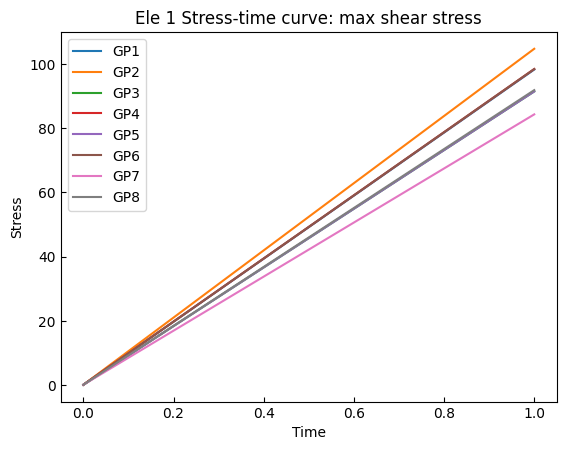

In [15]:
for gp_no in gauss_points:
    s = stresses2.sel(GaussPoints=gp_no)
    time = s.coords["time"].data
    plt.plot(time, s, label=f"GP{gp_no}")
plt.title("Ele 1 Stress-time curve: max shear stress")
plt.xlabel("Time")
plt.ylabel("Stress")
plt.legend()
plt.show()

We can also compute averages along a specific dimension. For example, below, we calculate the average stress at the Gauss points:

In [16]:
stresses2 = stress_measures.sel(measures="tau_max")
stresses3 = stresses2.mean(dim="GaussPoints")

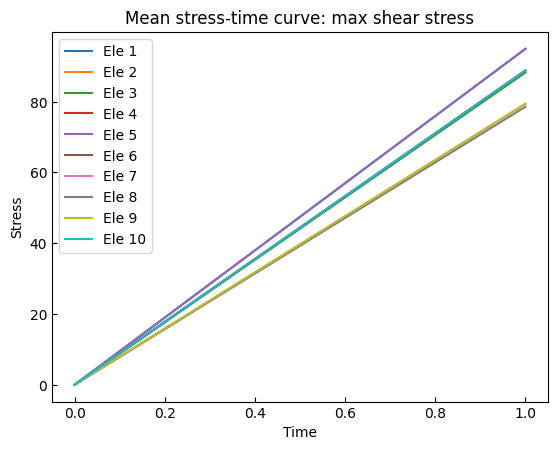

In [17]:
for eletag in np.arange(1, 11):
    s = stresses3.sel(eleTags=eletag)
    plt.plot(time, s, label=f"Ele {eletag}")
plt.title("Mean stress-time curve: max shear stress")
plt.xlabel("Time")
plt.ylabel("Stress")
plt.legend()
plt.show()

### Results at nodes

In [18]:
stress_measures = all_resp["StressMeasuresAtNodes"]
stresses = stress_measures.sel(measures="tau_max")

In [19]:
print(stresses.dims)

('time', 'nodeTags')


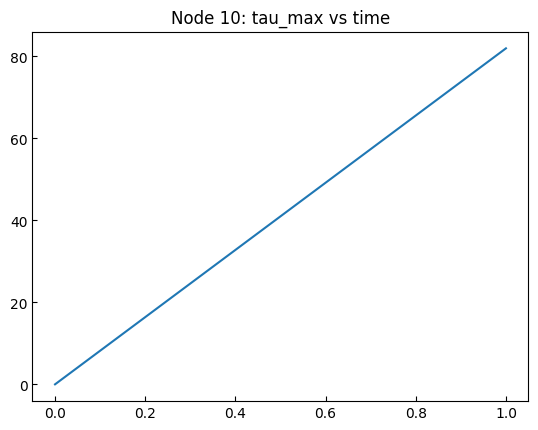

In [20]:
plt.plot(stresses.time, stresses.sel(nodeTags=10))
plt.title("Node 10: tau_max vs time")
plt.show()